<a href="https://colab.research.google.com/github/Lenflammeur/UCL-MSc_Project/blob/main/TCN_TimeSeries_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load Library

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from tqdm.notebook import tqdm
import tensorflow as tf

from tcn import TCN

### Read the dataset


In [31]:
df = pd.read_csv('all_stocks_5yr.csv', delimiter=',')


## APPLE Stock

In [34]:
df_AAPL = df.query("Name == 'AAPL'")
df_AAPL.shape


,date,open,high,low,close,volume,Name
1259,2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL
1260,2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL
1261,2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL
1262,2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL
1263,2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL


### Display top5 Record

In [ ]:
df_AAPL.head()

In [35]:
pd.options.plotting.backend = "plotly"
df_AAPL.plot(x='date', y='close')

In [36]:
close_aapl = df_AAPL['close'].values


To monitor training progress and compare evaluation metrics for different models, we'll use the function below to plot metrics captured from the training job such as training and validation loss or accuracy.

In [5]:
def plot_curves(train_data, val_data, label='Accuracy'):
    """Plot training and validation metrics on single axis.

    Args:
        train_data: list, metrics obtrained from training data.
        val_data: list, metrics obtained from validation data.
        label: str, title and label for plot.
    Returns:
        Matplotlib plot.
    """
    plt.plot(np.arange(len(train_data)) + 0.5,
             train_data,
             "b.-", label="Training " + label)
    plt.plot(np.arange(len(val_data)) + 1,
             val_data, "r.-",
             label="Validation " + label)
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel(label)
    plt.grid(True)  

In [37]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)


### Lookback 12 month windows

In [38]:
lookback_window = 12 

### Convert in to X, y format

In [44]:
X_train, y_train = split_sequence(close_aapl, lookback_window)

In [45]:
print(X_train.shape)
print(y_train.shape)

(1247, 12)
(1247,)


### Model Design

In [46]:
i = Input(shape=(lookback_window, 1))
m = TCN()(i)
m = Dense(1, activation='linear')(m)
model = Model(inputs=[i], outputs=[m])


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 12, 1)]           0         
_________________________________________________________________
tcn (TCN)                    (None, 64)                136256    
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 136,321
Trainable params: 136,321
Non-trainable params: 0
_________________________________________________________________


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 12, 1)]           0         
_________________________________________________________________
tcn (TCN)                    (None, 64)                136256    
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 136,321
Trainable params: 136,321
Non-trainable params: 0
_________________________________________________________________


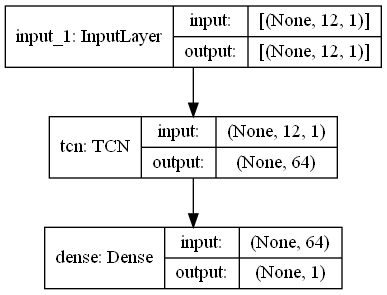

In [63]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [47]:
model.compile('adam','mae')

### Time for Model training...

In [48]:
print('Train...')
model.fit(X_train, y_train, epochs=100)

Train...
Epoch 1/100
39/39 [==============================] - 7s 17ms/step - loss: 249.3728
Epoch 2/100
39/39 [==============================] - 1s 16ms/step - loss: 28.2212
Epoch 3/100
39/39 [==============================] - 1s 16ms/step - loss: 17.5779
Epoch 4/100
39/39 [==============================] - 1s 17ms/step - loss: 9.6804
Epoch 5/100
39/39 [==============================] - 1s 15ms/step - loss: 7.2958
Epoch 6/100
39/39 [==============================] - 1s 16ms/step - loss: 7.0203
Epoch 7/100
39/39 [==============================] - 1s 16ms/step - loss: 21.7773
Epoch 8/100
39/39 [==============================] - 1s 17ms/step - loss: 7.8873
Epoch 9/100
39/39 [==============================] - 1s 16ms/step - loss: 12.1261
Epoch 10/100
39/39 [==============================] - 1s 16ms/step - loss: 6.0460
Epoch 11/100
39/39 [==============================] - 1s 17ms/step - loss: 6.3716
Epoch 12/100
39/39 [==============================] - 1s 20ms/step - loss: 4.7087
Epoch 13/1

### Prediction with TCN Model

In [49]:
predict = model.predict(X_train)

### Plot the Result

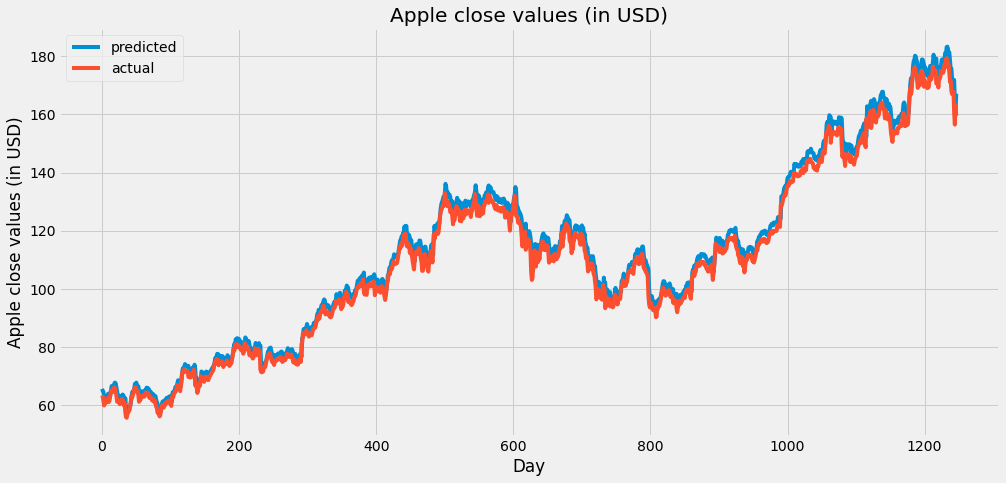

In [51]:
plt.style.use("fivethirtyeight")
plt.figure(figsize = (15,7))
plt.plot(predict)
plt.plot(y_train)
plt.title('Apple close values (in USD)')
plt.legend(['predicted', 'actual'])
plt.xlabel("Day")
plt.ylabel("Apple close values (in USD)")
plt.show()

### Inversing the model

In [52]:
from tensorflow.keras.layers import UpSampling1D
from tensorflow import keras

In [72]:
y_train_inverse = y_train.reshape((y_train.shape[0], 1))
y_train_inverse.shape

(1247, 1)

In [83]:
model_inverse = keras.models.Sequential()
model_inverse.add(keras.layers.InputLayer(input_shape=[1, 1]))
model_inverse.add(keras.layers.UpSampling1D(64))
model_inverse.add(TCN())
model_inverse.add(keras.layers.Dense(12, activation='linear'))
model_inverse.add(keras.layers.Reshape((12, 1), input_shape=(12, )))

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling1d_8 (UpSampling1 (None, 64, 1)             0         
_________________________________________________________________
tcn_7 (TCN)                  (None, 64)                136256    
_________________________________________________________________
dense_7 (Dense)              (None, 12)                780       
_________________________________________________________________
reshape (Reshape)            (None, 12, 1)             0         
Total params: 137,036
Trainable params: 137,036
Non-trainable params: 0
_________________________________________________________________


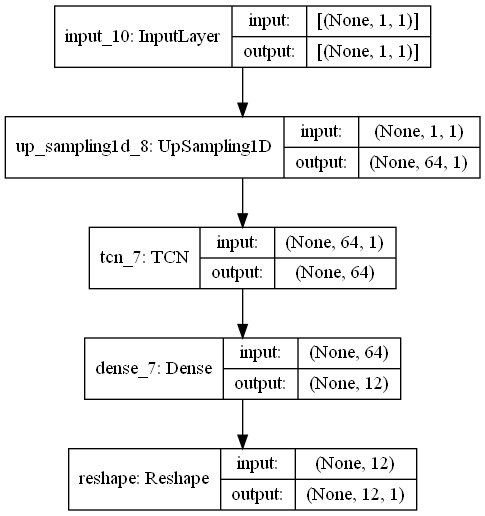

In [84]:
model_inverse.summary()
tf.keras.utils.plot_model(model_inverse, show_shapes=True)

In [85]:
model_inverse.compile('adam','mae')

In [86]:
test = y_train_inverse.reshape((1247, 1, 1))

In [87]:
print('Train...')
history = model_inverse.fit(test, X_train, epochs=2)

Train...
Epoch 1/2
39/39 [==============================] - 8s 58ms/step - loss: 415.2209
Epoch 2/2
39/39 [==============================] - 2s 57ms/step - loss: 37.4024
